# DPLE: process DPLE bottom fields for FEISTY
 - Based on notebook Liz,  Steve, and Who's 'DPLE_ENSO_check.ipynb' notebook from RAPCDI-analysis repo
 - data I/O functions based on template from daniel kennedy (djk2120@ucar.edu): https://github.com/djk2120/cesm-lens

In [1]:
import xarray as xr 
import numpy as np  
import os
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [2]:
# # Close out Dask Cluster and release workers:
# # NOTE:  only run this cell to terminate Dask Cluster!
# cluster.close()
# client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are currently hard-wired to retrieve ocean monthly data

In [5]:
def file_dict(filetempl,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given experiment, field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    filetemp = filetempl.replace('MM',monstr).replace('EEE',memstr)

    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split('.pop.h.')[0]
        y0 = int(ystr[-11:-7])
        filepaths[y0]=file
        
    return filepaths

In [6]:
def nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(filetemplate,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [7]:
## NOTE
## Regulate dask array size using this proprocess function.
## Set appropriately based on analysis to come.

def preprocess(ds):
    #return ds.isel(z_t=slice(0,15)).isel(time=slice(0,24))
    return ds.isel(time=slice(0,24))

def open_members(in_obj):
    ffs = in_obj[0]  #unwrap the list
    field = in_obj[1]
    ens = in_obj[2]
    lm = in_obj[3]
    chunks = in_obj[4]
    var_name = f'{field}_bottom'
    
    d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,concat_dim='M',data_vars=[var_name],\
                           chunks=chunks,compat='override', coords='minimal') #, preprocess=preprocess)
    #added compat=override, coords=minimal here. Assumes that all hindcasts have same dims/coords. Seems a little dangerous
    #but REALLY speeds things up. And we know that the coords are the same for all of SMYLE anyway.

    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    d0 = d0.assign_coords(M=("M",ens))
    d0 = d0.assign_coords(L=("time",lm))
    d0 = d0.swap_dims({'time': 'L'})
    d0 = d0.reset_coords(["time"])
    
    return d0

In [8]:
def get_monthly_data(filetemplate,ens,leads,field,firstyear,lastyear,stmon,chunks={}):
    ''' returns dask array containing the requested hindcast ensemble '''

    ds = xr.Dataset()    #instantiate Dataset
    lm = np.array(leads)+1
    files,yrs = nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon)
    ens = np.array(ens)+1
    var_name = f'{field}_bottom'
    
    # all members should have the same number of files, otherwise abort
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        complete_set=True   # same number of files
    else:
        raise ValueError('ERROR: Incomplete set of files')
        
    if complete_set: #read all data using map/gather
        dsets = []
        in_obj = [[ffs, field, ens, lm, chunks] for ffs in files]
        dsets = client.map(open_members, in_obj)
        dsets = client.gather(dsets)
        tmp = xr.concat(dsets,dim='Y',data_vars=[var_name,'time','time_bound'], coords='minimal', compat='override')
        #replaced "field" by "var_name" above
        #potentially dangerous compat/coords option - xarray is NOT checking that the coordinates 
        #are the same across all files - pulling values of shared coords from the first file only
        #speeds up read-in time by ~1/3
        tmp = tmp.assign_coords(Y=("Y",yrs))

    ds[var_name] = tmp[var_name]
    ds['dz'] = tmp['dz'] #added
    ds['KMT'] = tmp['KMT'] #added
    ds['time'] = tmp['time']
    ds['time_bound'] = tmp['time_bound']
    ds['TAREA'] = tmp['TAREA']
    #ds['UAREA'] = tmp['UAREA']

    return ds

In [9]:
client

Client Scheduler: tcp://10.12.206.51:34497 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [10]:
%%time
# DPLE data
# process all 40 ensemble members, first 24 months, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/scratch/kristenk/DPLE-tmpfiles'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
#filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
filetemplate = datadir+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
leadtimes = range(122)
#leadtimes = range(24)
firstyear = 1954
lastyear  = 2017
startmonth = 11
#chunks={'z_t':60,'nlat':80} #un-commented and change z_t to 15
dple_temp = get_monthly_data(filetemplate,ens,leadtimes,field,firstyear,lastyear,startmonth)
dple_temp.nbytes/1e9 #GB
var_name = f'{field}_bottom'

CPU times: user 17.4 s, sys: 7.08 s, total: 24.5 s
Wall time: 41.7 s


In [11]:
# Load this in memory to speed up later computations
dple_temp = dple_temp.persist()

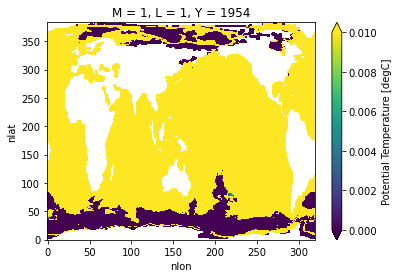

In [12]:
dple_temp[var_name].isel(M=0,L=0,Y=0).plot(vmin=0,vmax=0.01)

In [13]:
dso_anoms = xr.Dataset()

### Drift removal
##### • Drift removal by lead time

In [14]:
%%time

dple_time_bound = dple_temp.time_bound.load()

#Set the start and end year (inclusive) for the climotology
cl_y1 = 1964
cl_y2 = 2014

cl_d1 = cftime.DatetimeNoLeap(cl_y1,1,1,0,0,0)
cl_d2 = cftime.DatetimeNoLeap(cl_y2,12,31,23,59,59)

print('doing variable', var_name)

fordrift = dple_temp[var_name].where((dple_time_bound.mean('d2')>cl_d1) & (dple_time_bound.mean('d2')<cl_d2))
climodrift = fordrift.mean('M').mean('Y')

dso_anoms[var_name] = dple_temp[var_name] - climodrift

doing variable TEMP_bottom
CPU times: user 286 ms, sys: 17.5 ms, total: 304 ms
Wall time: 349 ms


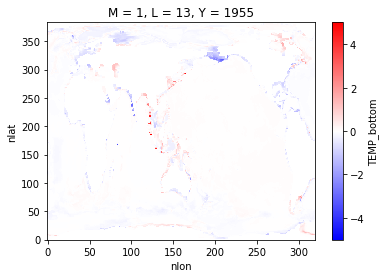

In [15]:
dso_anoms[var_name].isel(Y=1,M=0,L=12).plot(cmap='bwr')

### write out the data
##### • one netcdf per variable

In [16]:
%%time
USER = os.environ['USER']
dout = f'/glade/scratch/{USER}/fish-offline'
os.makedirs(dout, exist_ok=True)

CPU times: user 400 µs, sys: 93 µs, total: 493 µs
Wall time: 5.68 ms


In [17]:
%%time
dso_anoms.load()

CPU times: user 1min 57s, sys: 10min 41s, total: 12min 38s
Wall time: 22min 25s


<xarray.Dataset>
Dimensions:      (L: 122, M: 40, Y: 64, nlat: 384, nlon: 320)
Coordinates:
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * M            (M) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * L            (L) int64 1 2 3 4 5 6 7 8 9 ... 115 116 117 118 119 120 121 122
  * Y            (Y) int64 1954 1955 1956 1957 1958 ... 2013 2014 2015 2016 2017
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP_bottom  (Y, M, L, nlat, nlon) float32 nan nan nan nan ... nan nan nan

In [18]:
%%time
dso_anoms.to_netcdf(f'{dout}/DPLE-FIESTY-forcing_{var_name}.nc', mode='w')

CPU times: user 209 ms, sys: 32.9 s, total: 33.1 s
Wall time: 42.6 s


In [19]:
cluster.close()